In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of gallifrey, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [147]:
import yt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gallifrey.setup import data_setup
from gallifrey.utilities.math import calculate_pca
from gallifrey.particles import rotated_dataset
from gallifrey.visualization.visualization_utils import (
    set_plot_defaults,
    get_palette,
    FigureProcessor,
    contourplot,
)

## DATA SETUP

In [4]:
snapshot = 127
resolution = 4096
sim_id = "09_18"
num_embryos = 50
host_star_masses = 1
planet_categories = [
    "Earth",
    "Super-Earth",
    "Neptunian",
    "Sub-Giant",
    "Giant",
    "D-Burner",
]
save = False

In [5]:
ds, mw, stellar_model, imf, planet_model = data_setup(
    snapshot=snapshot,
    resolution=resolution,
    sim_id=sim_id,
    ngpps_num_embryos=num_embryos,
    ngpps_star_masses=host_star_masses,
)


      DETECTED LOCAL MACHINE: Test snapshot loaded.

yt : [INFO     ] 2023-09-06 15:19:39,612 Calculating time from 1.000e+00 to be 4.318e+17 seconds
yt : [INFO     ] 2023-09-06 15:19:39,663 Parameters: current_time              = 4.318436660023809e+17 s
yt : [INFO     ] 2023-09-06 15:19:39,664 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-09-06 15:19:39,664 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-09-06 15:19:39,665 Parameters: domain_right_edge         = [100. 100. 100.]
yt : [INFO     ] 2023-09-06 15:19:39,665 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-09-06 15:19:39,666 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2023-09-06 15:19:39,666 Parameters: omega_lambda              = 0.682
yt : [INFO     ] 2023-09-06 15:19:39,666 Parameters: omega_matter              = 0.318
yt : [INFO     ] 2023-09-06 15:19:39,667 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 202

## PLOT SETUP

In [6]:
set_plot_defaults()
figure_directory = "Galaxy_Components"

## CREATE DATA SOURCE

In [7]:
radius = 80  # can contain a cube of 80/sqrt(3) = 46 kpc, so plots with a smaller width will have no edge effects
normal_vector = calculate_pca(
    mw.sphere(radius=(10, "kpc"))["stars", "Coordinates"]
).components_[-1]

In [73]:
sphere_data = mw.sphere(radius=ds.quan(radius, "kpc"))

rotated_sphere_data = rotated_dataset(
    sphere_data,
    mw.centre(),
    normal_vector,
    [
        ("stars", "[Fe/H]"),
        ("stars", "[alpha/Fe]"),
        ("stars", "particle_velocity_x"),
        ("stars", "particle_velocity_y"),
        ("stars", "particle_velocity_z"),
    ],
)

yt : [INFO     ] 2023-09-06 16:02:42,626 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-09-06 16:02:42,627 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-09-06 16:02:42,628 Parameters: domain_left_edge          = [-78.5896246 -78.5896246 -78.5896246]
yt : [INFO     ] 2023-09-06 16:02:42,628 Parameters: domain_right_edge         = [79.26039752 79.26039752 79.26039752]
yt : [INFO     ] 2023-09-06 16:02:42,629 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-09-06 16:02:42,633 Allocating for 3.463e+05 particles


## [α/Fe] - [Fe/H] DIAGRAM

In [9]:
import pandas as pd
import seaborn as sns

fields = ("[Fe/H]", "[alpha/Fe]")

data = pd.DataFrame(
    np.array([sphere_data["stars", field].value for field in fields]).T, columns=fields
)

(0.0, 0.3)

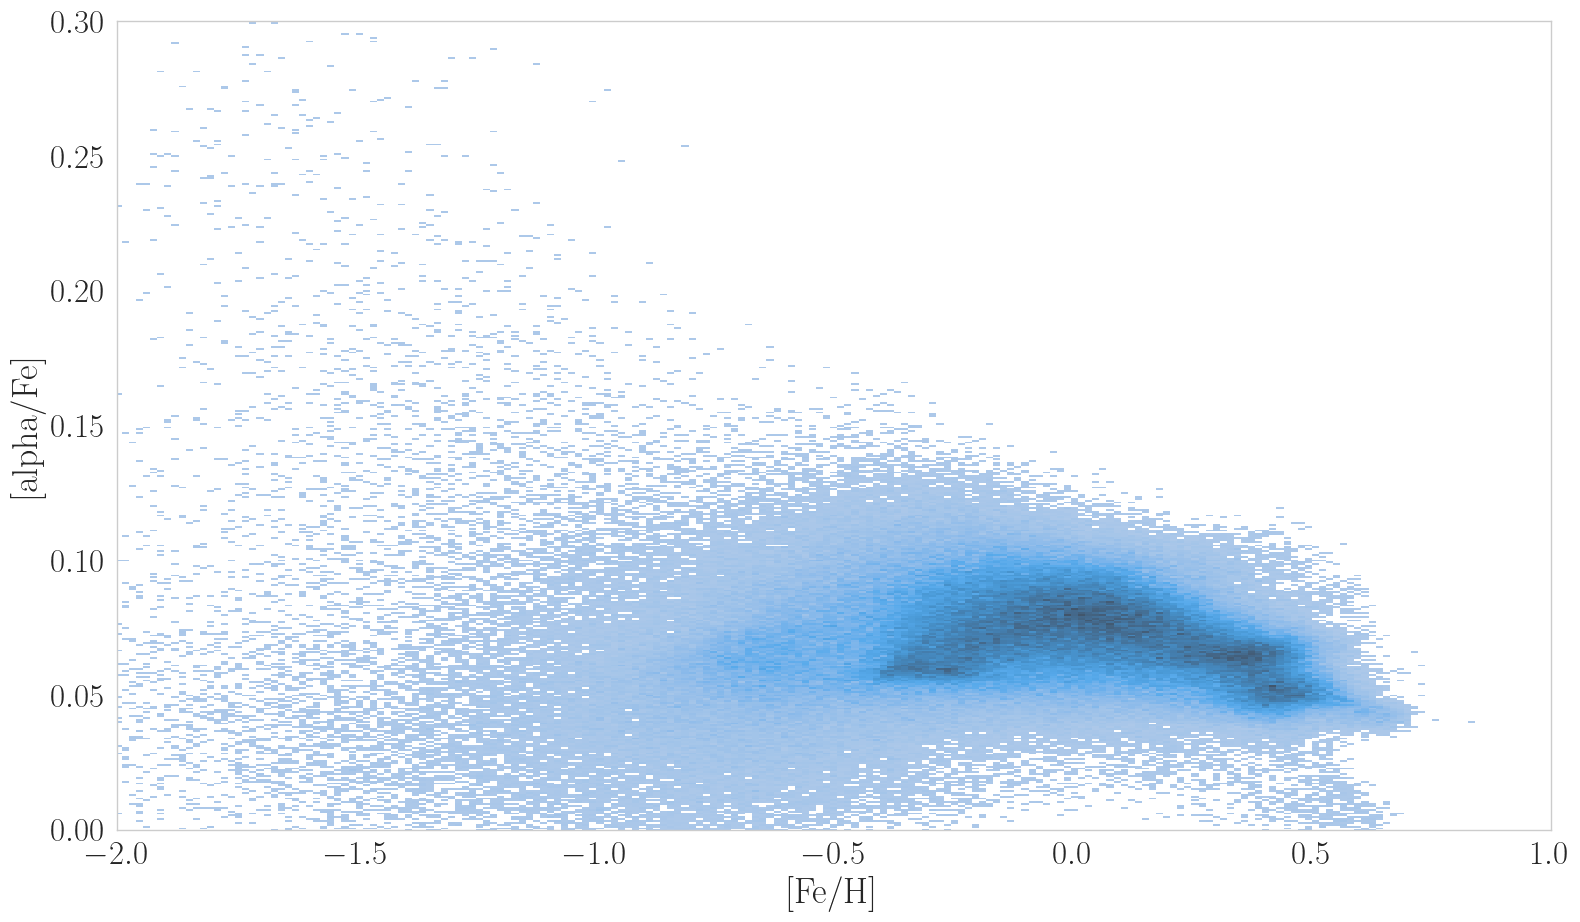

In [10]:
fig, ax = plt.subplots()
ax = sns.histplot(data, x=fields[0], y=fields[1])
ax.set_xlim(-2, 1)
ax.set_ylim(0, 0.3)

## PLAYING AROUD

In [32]:
rotated_sphere_data.derived_field_list

[('all', '[Fe/H]'),
 ('all', '[alpha/Fe]'),
 ('all', 'particle_angular_momentum'),
 ('all', 'particle_angular_momentum_magnitude'),
 ('all', 'particle_angular_momentum_x'),
 ('all', 'particle_angular_momentum_y'),
 ('all', 'particle_angular_momentum_z'),
 ('all', 'particle_mass'),
 ('all', 'particle_masses'),
 ('all', 'particle_ones'),
 ('all', 'particle_position'),
 ('all', 'particle_position_cylindrical_radius'),
 ('all', 'particle_position_cylindrical_theta'),
 ('all', 'particle_position_cylindrical_z'),
 ('all', 'particle_position_relative_x'),
 ('all', 'particle_position_relative_y'),
 ('all', 'particle_position_relative_z'),
 ('all', 'particle_position_spherical_phi'),
 ('all', 'particle_position_spherical_radius'),
 ('all', 'particle_position_spherical_theta'),
 ('all', 'particle_position_x'),
 ('all', 'particle_position_y'),
 ('all', 'particle_position_z'),
 ('all', 'particle_radial_velocity'),
 ('all', 'particle_radius'),
 ('all', 'particle_specific_angular_momentum'),
 ('all'

In [45]:
rotated_sphere_data.r["stars", "particle_position_cylindrical_radius"]

YTDimensionalityError: Dimensionality specified was 2 but we need 3

In [46]:
rotated_sphere_data.dimensionality

3

In [121]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [154]:
import pandas as pd
import seaborn as sns

fields = ("[Fe/H]", "[alpha/Fe]", "perp_radius", "particle_position_z")

data = pd.DataFrame(
    np.array([rotated_sphere_data.r["stars", field].value for field in fields]).T,
    columns=fields,
)

In [155]:
data

,[Fe/H],[alpha/Fe],perp_radius,particle_position_z
0,0.089985,0.058263,0.199501,0.019603
1,0.044718,0.065754,0.233658,-0.144969
2,0.056717,0.080821,0.548065,0.044641
3,0.133194,0.040279,0.206988,0.231084
4,-0.923878,0.091125,0.283929,0.144679
...,...,...,...,...
346337,-1.374383,-0.021267,55.878278,-47.410079
346338,-1.387311,-0.004764,58.710843,-49.544607
346339,-1.832631,-0.007412,58.478843,-47.467020
346340,-1.308631,-0.014931,54.673303,-49.759683


In [150]:
gm = GaussianMixture(n_components=3).fit(data)

In [151]:
pd.DataFrame(gm.means_)

,0,1,2,3
0,0.169443,0.068424,0.657311,-0.448744
1,-1.320558,0.067926,0.827999,-0.072634
2,-0.301028,0.070999,0.679263,0.079487


(-10.0, 10.0)

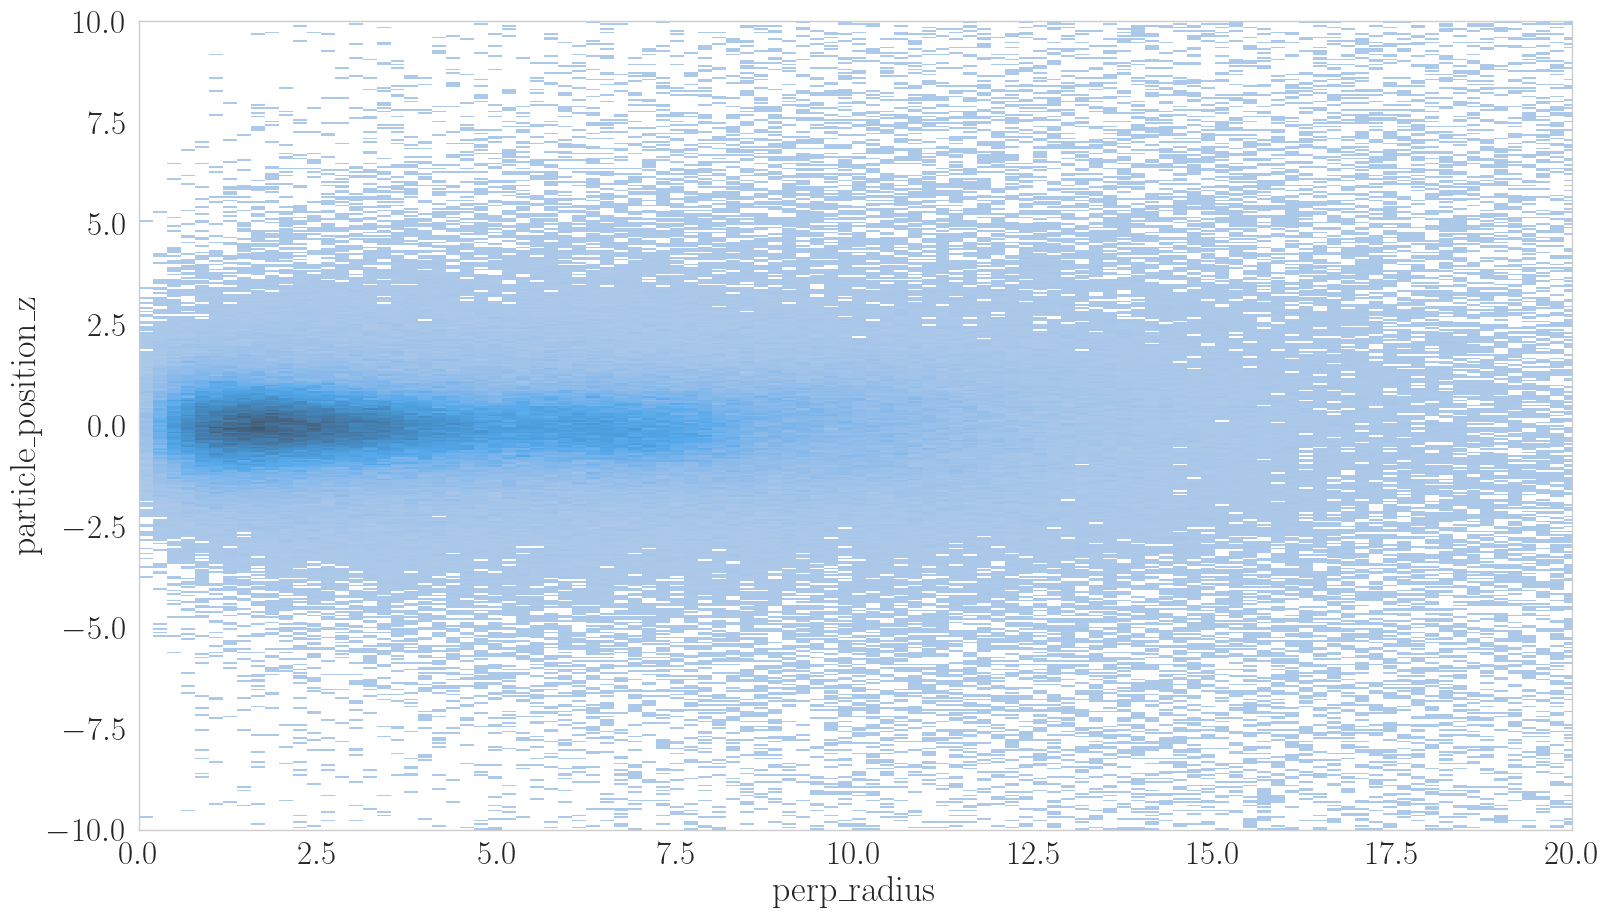

In [161]:
fig, ax = plt.subplots()
ax = sns.histplot(data, x="perp_radius", y="particle_position_z")
ax.set_xlim(0, 20)
ax.set_ylim(-10, 10)